In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

from draw_strokes import draw_strokes

from experiment import run_epoch
from lstm import LSTMGenerator, LSTMDiscriminator
from lstm_data import LSTMDataset, create_mask, create_batch_mask, revert

DATA_PATH = "sheep_market.npz"
data = np.load(DATA_PATH, allow_pickle=True, encoding="bytes")
train_raw_data = data["train"]
valid_raw_data = data["valid"]
test_raw_data = data["test"]

MEAN = [0.3776045376257754, 0.30774983488947305]
STD = [21.851689358105794, 14.4384627726713]


In [2]:
DIM = 4
H_DIM = 16
LAYERS = 4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 0 if DEVICE == "cpu" else 2

generator = LSTMGenerator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)
discriminator = LSTMDiscriminator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)

generator.to(DEVICE)
discriminator.to(DEVICE)
    
train = LSTMDataset(train_raw_data, MEAN, STD)
valid = LSTMDataset(valid_raw_data, MEAN, STD)
test = LSTMDataset(test_raw_data, MEAN, STD)


In [3]:
GENERATOR_PATH = "weights/gen.pth"
DIM = 4
H_DIM = 64
LAYERS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

generator = LSTMGenerator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)
generator.load(GENERATOR_PATH)


In [7]:
z = torch.normal(torch.zeros(1, 251, H_DIM), 1) # B, H
gen = generator(z)
gen = revert(gen, MEAN, STD)
print(gen)

# draw_strokes(gen)


[[-1 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]
 [-2 -2 0]

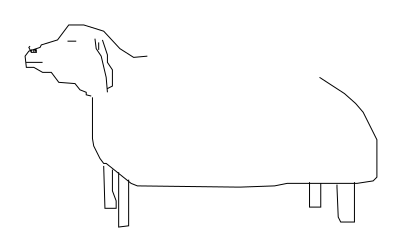

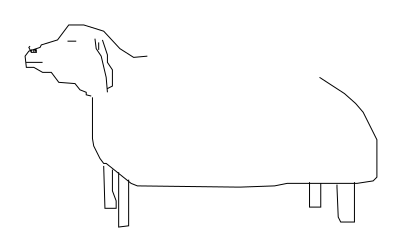

In [13]:
ITEM = 10

rev = revert(train[ITEM], MEAN, STD)
raw = train_raw_data[ITEM]

draw_strokes(rev)
draw_strokes(raw)
